In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [2]:
d2l.set_figsize()
img = d2l.Image.open('../pytorch/img/cat1.jpg')

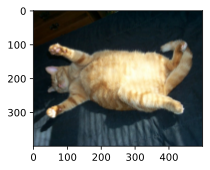

In [6]:
d2l.plt.imshow(img)

In [7]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

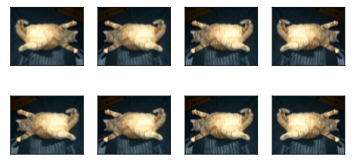

In [8]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

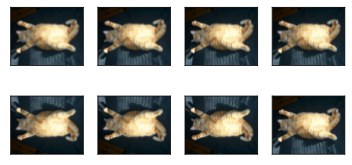

In [9]:
apply(img, torchvision.transforms.RandomVerticalFlip())

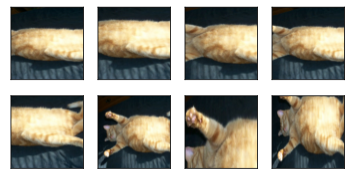

In [10]:
shape_aug = torchvision.transforms.RandomResizedCrop((200, 200),
                                                    scale=(0.1, 1),
                                                    ratio=(0.5, 2))
apply(img, shape_aug)

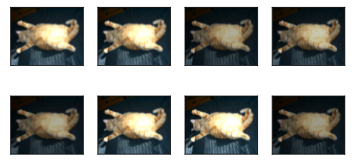

In [8]:
apply(img, torchvision.transforms.ColorJitter(
brightness=0.5, contrast=0, saturation=0, hue=0))

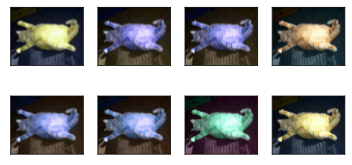

In [9]:
apply(img, torchvision.transforms.ColorJitter(
brightness=0, contrast=0, saturation=0, hue=0.5))

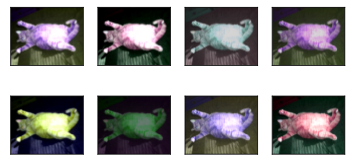

In [10]:
apply(img, torchvision.transforms.ColorJitter(
brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5))

In [11]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(
brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    torchvision.transforms.RandomResizedCrop((200, 200),
                                                    scale=(0.1, 1),
                                                    ratio=(0.5, 2))
])

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../pytorch/data/cifar-10-python.tar.gz to ../pytorch/data


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

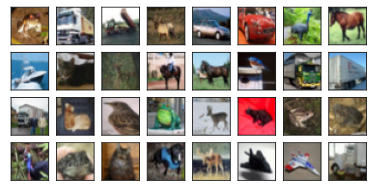

In [12]:
all_images = torchvision.datasets.CIFAR10(train=True,
                                         root='../pytorch/data',
                                         download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)

In [11]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(
brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    torchvision.transforms.RandomResizedCrop((200, 200),
                                                    scale=(0.1, 1),
                                                    ratio=(0.5, 2)),
    torchvision.transforms.ToTensor()
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [12]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root='../pytorch/data',
                                          train=is_train,
                                          transform=augs,
                                          download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                            shuffle=is_train, 
                                             num_workers=d2l.get_dataloader_workers())
    return dataloader

In [26]:
#@save
def train_batch_ch13(net, X, y, loss, trainer, device):
    """Train for a minibatch with multiple GPUs (defined in Chapter 13)."""
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(device) for x in X]
    else:
        X = X.to(device)
    y = y.to(device)
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [35]:
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               device=d2l.try_gpu()):
    """Train a model with multiple GPUs (defined in Chapter 13)."""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = net.to(device)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, device)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [28]:
def init_cnn(module):
    """Initialize weights for CNNs.

    Defined in :numref:`sec_lenet`"""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

In [33]:
batch_size, device, net = 256, d2l.try_gpu(), d2l.resnet18(10, 3)
print(device)
net.apply(init_cnn)

cuda:0


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (resnet_block1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (resnet_block2): Sequential(
   

In [34]:
def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    net(next(iter(train_iter))[0])
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, device)

loss 1.344, train acc 0.525, test acc 0.142
351.5 examples/sec on [device(type='cuda', index=0)]


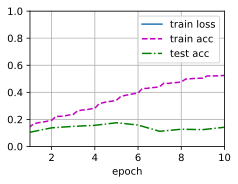

In [36]:
train_with_data_aug(train_augs, test_augs, net)